Step 1: Load and Inspect

In [2]:
import pandas as pd

df = pd.read_csv("titanic.csv")
print(df.head())
print(df.info())
print(df.shape)

   PassengerId  Survived  Pclass  \
0            1         0       3   
1            2         1       1   
2            3         1       3   
3            4         1       1   
4            5         0       3   

                                                Name     Sex   Age  SibSp  \
0                            Braund, Mr. Owen Harris    male  22.0      1   
1  Cumings, Mrs. John Bradley (Florence Briggs Th...  female  38.0      1   
2                             Heikkinen, Miss. Laina  female  26.0      0   
3       Futrelle, Mrs. Jacques Heath (Lily May Peel)  female  35.0      1   
4                           Allen, Mr. William Henry    male  35.0      0   

   Parch            Ticket     Fare Cabin Embarked  
0      0         A/5 21171   7.2500   NaN        S  
1      0          PC 17599  71.2833   C85        C  
2      0  STON/O2. 3101282   7.9250   NaN        S  
3      0            113803  53.1000  C123        S  
4      0            373450   8.0500   NaN        S  
<c

Step 2: Select Features

Drop unneeded columns like PassengerId, Name, Ticket.

In [3]:
df.drop(columns=['PassengerId', 'Name', 'Ticket'], inplace=True)

Step 3: Handle Missing Values
1. Age (Numerical): 177 missing

We'll fill with the median age, which is more robust to outliers than the mean.
2. Embarked (Categorical): 2 missing

Fill with the most frequent value (mode).
3. Cabin (High missing ratio): 687 missing

    Over 77% of the values are missing.

    Best option: drop this column, unless you want to do feature engineering (e.g., extract deck info).

In [4]:
df['Age'].fillna(df['Age'].median(), inplace=True)
df['Embarked'].fillna(df['Embarked'].mode()[0], inplace=True)
df.drop('Cabin', axis=1, inplace=True)

C:\Users\Lenovo\AppData\Local\Temp\ipykernel_27216\4232182175.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['Age'].fillna(df['Age'].median(), inplace=True)


Checking Null Values again

In [6]:
df.isnull().sum()  # Checking for null values again
print(df.shape)

(891, 8)


 Step 4: Encode Categorical Features

In [9]:
# One-Hot Encode 'Sex' and 'Embarked'
df_encoded = pd.get_dummies(df, columns=['Sex', 'Embarked'], drop_first=True)

# Check the result
print(df_encoded.head())


   Survived  Pclass   Age  SibSp  Parch     Fare  Sex_male  Embarked_Q  \
0         0       3  22.0      1      0   7.2500      True       False   
1         1       1  38.0      1      0  71.2833     False       False   
2         1       3  26.0      0      0   7.9250     False       False   
3         1       1  35.0      1      0  53.1000     False       False   
4         0       3  35.0      0      0   8.0500      True       False   

   Embarked_S  
0        True  
1       False  
2        True  
3        True  
4        True  


In [17]:
df_encoded['Parch'].unique()

array([0, 1, 2, 5, 3, 4, 6], dtype=int64)

Step 5: Outlier Detection
    Method 1: Visualization (Boxplots)
    Method 2: IQR (Interquartile Range)

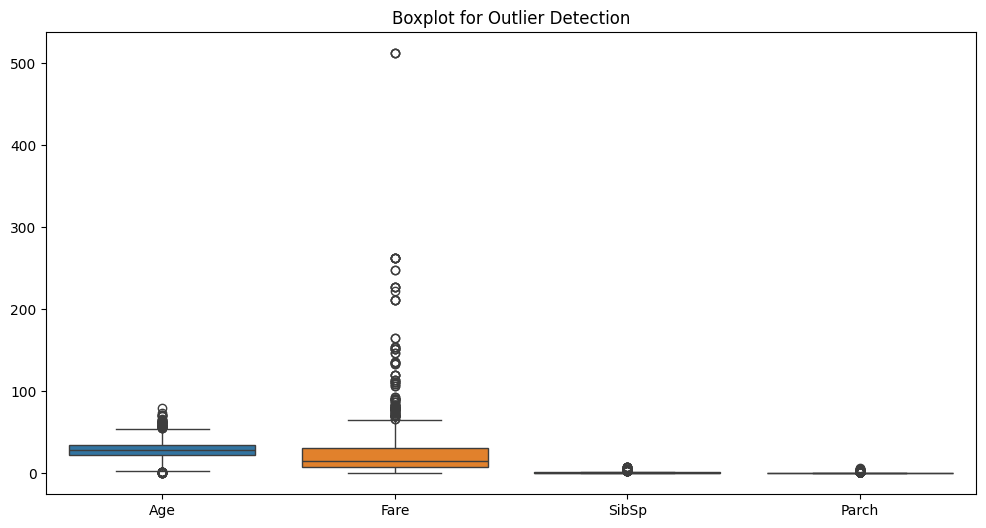

In [14]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
sns.boxplot(data=df_encoded[['Age', 'Fare', 'SibSp', 'Parch']])
plt.title('Boxplot for Outlier Detection')
plt.show()


In [18]:
# Define function to detect outliers using IQR
def detect_outliers_iqr(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    return df[(df[column] < lower) | (df[column] > upper)]

# Example: Find outliers in 'Fare'
features = ['Age', 'SibSp', 'Parch', 'Fare']
for feature in features:
    outliers = detect_outliers_iqr(df_encoded, feature)
    print(f'No. of {feature} outliers: {outliers.shape[0]}')

No. of Age outliers: 66
No. of SibSp outliers: 46
No. of Parch outliers: 213
No. of Fare outliers: 116


Dealing with Outliers:
1. Cap Extreme Ages
2. Keep SibSp as is
3. Cap Parch similarly to Age
4. Cap Fare or Log-transform it

In [19]:
lower_age = df_encoded['Age'].quantile(0.01)
upper_age = df_encoded['Age'].quantile(0.99)

df_encoded['Age'] = df_encoded['Age'].clip(lower=lower_age, upper=upper_age)


In [ ]:
lower_parch = df_encoded['Parch'].quantile(0.01)
upper_parch = df_encoded['Parch'].quantile(0.99)

df_encoded['Parch'] = df_encoded['Parch'].clip(lower=lower_parch, upper=upper_parch)


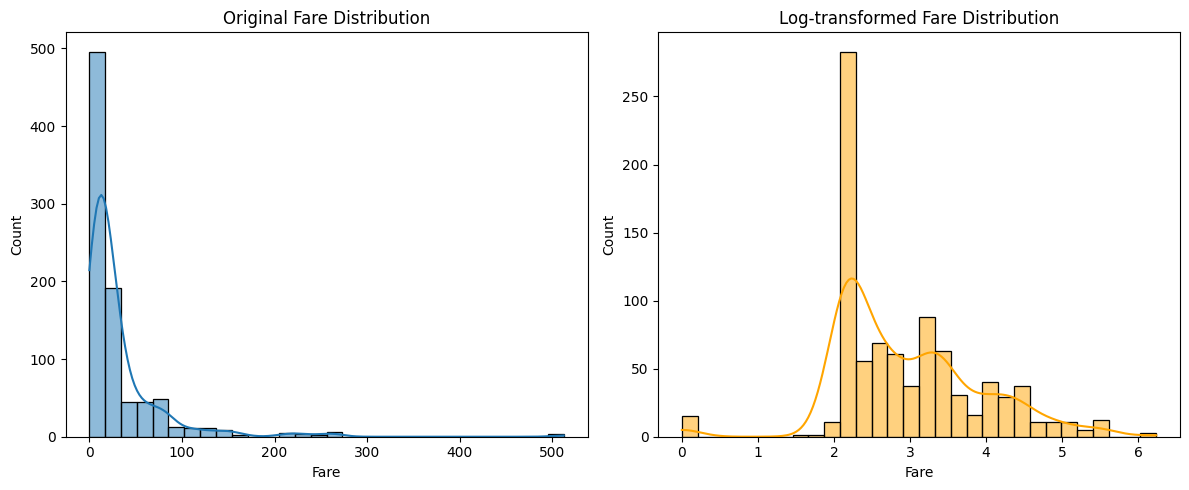

In [25]:
df_encoded['Fare'] = df['Fare']

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

plt.figure(figsize=(12, 5))

# Original Fare distribution
plt.subplot(1, 2, 1)
sns.histplot(df_encoded['Fare'], bins=30, kde=True)
plt.title('Original Fare Distribution')

# Log-transformed Fare distribution (add 1 to avoid log(0))
plt.subplot(1, 2, 2)
sns.histplot(np.log1p(df_encoded['Fare']), bins=30, kde=True, color='orange')
plt.title('Log-transformed Fare Distribution')

plt.tight_layout()
plt.show()


In [26]:
import numpy as np

upper_fare = df_encoded['Fare'].quantile(0.99)
df_encoded['Fare'] = df_encoded['Fare'].clip(upper=upper_fare)

# Add log-transformed fare (+1 to avoid log(0))
df_encoded['Fare'] = np.log1p(df_encoded['Fare'])


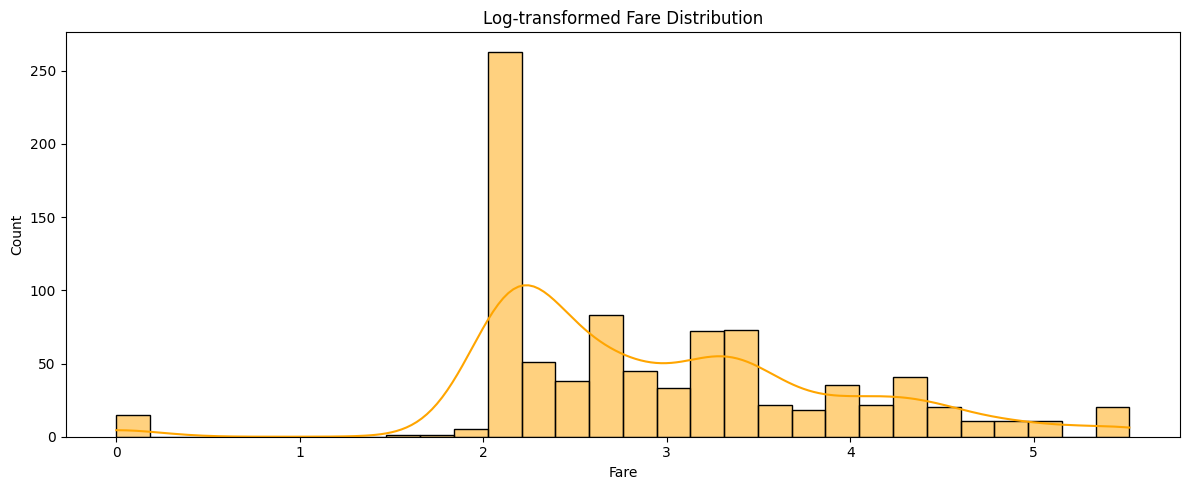

In [27]:
plt.figure(figsize=(12, 5))
sns.histplot(df_encoded['Fare'], bins=30, kde=True, color='orange')
plt.title('Log-transformed Fare Distribution')

plt.tight_layout()
plt.show()

Step 6: Feature Scaling

In [29]:
df_encoded.head()

,Survived,Pclass,Age,SibSp,Parch,Fare,Sex_male,Embarked_Q,Embarked_S
0,0,3,22.0,1,0,2.110213,True,False,True
1,1,1,38.0,1,0,4.280593,False,False,False
2,1,3,26.0,0,0,2.188856,False,False,True
3,1,1,35.0,1,0,3.990834,False,False,True
4,0,3,35.0,0,0,2.202765,True,False,True


In [ ]:
from sklearn.preprocessing import StandardScaler

# List of features to scale
num_features = ['Age', 'SibSp', 'Parch', 'Fare']

# Initialize the scaler
scaler = StandardScaler()

# Fit and transform
df_encoded_scaled = df_encoded.copy()
df_encoded_scaled[num_features] = scaler.fit_transform(df_encoded[num_features])

# Preview
df_encoded_scaled[num_features].head()


,Age,SibSp,Parch,Fare
0,-0.569558,0.432793,-0.489905,-0.884451
1,0.677983,0.432793,-0.489905,1.375893
2,-0.257673,-0.474545,-0.489905,-0.802548
3,0.444069,0.432793,-0.489905,1.074123
4,0.444069,-0.474545,-0.489905,-0.788063


In [31]:
df_encoded_scaled.head()

,Survived,Pclass,Age,SibSp,Parch,Fare,Sex_male,Embarked_Q,Embarked_S
0,0,3,-0.569558,0.432793,-0.489905,-0.884451,True,False,True
1,1,1,0.677983,0.432793,-0.489905,1.375893,False,False,False
2,1,3,-0.257673,-0.474545,-0.489905,-0.802548,False,False,True
3,1,1,0.444069,0.432793,-0.489905,1.074123,False,False,True
4,0,3,0.444069,-0.474545,-0.489905,-0.788063,True,False,True
